In [ ]:
pip install dicom2nifti

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import os
import glob, shutil, tempfile
#import dicom2nifti
#import dicom2nifti.settings as settings

In [ ]:
settings.disable_validate_orthogonal()

In [ ]:
DATASET_DIR = "/kaggle/input/data-ad/Dataset"   
OUTPUT_DIR  = "/kaggle/working/NIFTI_DATA99" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
def convert_subject(dicom_dir, out_dir, subj_id):
    try:
        with tempfile.TemporaryDirectory() as tmp_out:
            # convert dicoms into temp dir
            dicom2nifti.convert_directory(dicom_dir, tmp_out, compression=True, reorient=True)

            # find the nifti file created
            nii_files = glob.glob(os.path.join(tmp_out, "*.nii.gz"))
            if len(nii_files) == 0:
                print(f"⚠️ No NIfTI created for {subj_id}")
                return

            # we assume first nifti is the right one
            src_file = nii_files[0]
            dst_file = os.path.join(out_dir, f"{subj_id}.nii.gz")
            shutil.move(src_file, dst_file)

            print(f"✅ Converted {subj_id} → {dst_file}")

    except Exception as e:
        print(f"❌ Failed {subj_id}: {e}")

In [ ]:
for cls in os.listdir(DATASET_DIR):  
    cls_path = os.path.join(DATASET_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    out_cls_dir = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(out_cls_dir, exist_ok=True)

    for subj in os.listdir(cls_path):
        subj_path = os.path.join(cls_path, subj)
        if not os.path.isdir(subj_path):
            continue

        dicom_files = glob.glob(os.path.join(subj_path, "**", "*.dcm"), recursive=True)
        if len(dicom_files) == 0:
            print(f"⚠️ No DICOM found for {subj}")
            continue

        dicom_dir = os.path.dirname(dicom_files[0])
        convert_subject(dicom_dir, out_cls_dir, subj)

In [ ]:
!ls /kaggle/working/NIFTI_DATA/ADNI1_T1w_Cohort_AD_Visit_12_MRI | wc -l

In [ ]:
!zip -r NIFTI_DATA99.zip /kaggle/working/NIFTI_DATA99


In [ ]:
from IPython.display import FileLink
FileLink(r'NIFTI_DATA99.zip')

In [3]:
!pip install monai nibabel torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [4]:
import os
import torch
import nibabel as nib
import numpy as np
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Spacing,
    Orientation,
    ScaleIntensity,
    Resize,
    ToTensor
)
from monai.networks.nets import resnet
from tqdm import tqdm
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nibabel as nib

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-10-08 04:22:19.325099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759897339.570122      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759897339.637150      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
DATA_DIR = "/kaggle/input/nifti-data99/kaggle/working/NIFTI_DATA99"
EMBEDDING_SAVE_DIR = "/kaggle/working/MRI_Embeddings"
os.makedirs(EMBEDDING_SAVE_DIR, exist_ok=True)

In [6]:
preprocess = (
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    Spacing(pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    ScaleIntensity(),
    Resize(spatial_size=(128, 128, 128)),
    ToTensor()
)


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.array Orientation.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import os

print(os.listdir("/kaggle/input/resnet_50/pytorch/default/1"))

['resnet_50.pth']


In [8]:
from monai.networks.nets import resnet

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
num_classes = 3  # e.g. AD, MCI, CN
model = resnet.resnet50(spatial_dims=3, n_input_channels=1, num_classes=1000)
state_dict = torch.load("/kaggle/input/resnet_50/pytorch/default/1/resnet_50.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
print("✅ Loaded pretrained MedicalNet weights")

# 🔸 Replace final FC layer for fine-tuning
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)


✅ Loaded pretrained MedicalNet weights


In [11]:
# Unfreeze last 2 residual layers
unfreeze_layers = ["layer3", "layer4", "fc"]
for name, param in model.named_parameters():
    if any(l in name for l in unfreeze_layers):
        param.requires_grad = True
    else:
        param.requires_grad = False


In [12]:
model = model.to(device)
model.train()  # ✅ set to training mode

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64, 25

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
EPOCHS = 10

In [14]:
CLASS_TO_IDX = {"ADNI1_T1w_Cohort_AD_Visit_12_MRI": 0, "ADNI1_T1w_DXMCI=1_at_m18_MRI": 1, "ADNI1_T1w_Normal_at_m12_MRI": 2} 

In [15]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for cls in os.listdir(DATA_DIR):
        cls_dir = os.path.join(DATA_DIR, cls)
        if not os.path.isdir(cls_dir):
            continue

        nii_files = [f for f in os.listdir(cls_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
        label = CLASS_TO_IDX[cls]

        for file in tqdm(nii_files, desc=f"Epoch {epoch+1} - {cls}"):
            try:
                img_path = os.path.join(cls_dir, file)
                img = nib.load(img_path).get_fdata()
                img = np.nan_to_num(img)
                img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                img = F.interpolate(img, size=(128, 128, 128), mode="trilinear", align_corners=False).to(device)
                label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                optimizer.zero_grad()
                output = model(img)
                loss = criterion(output, label_tensor)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += (pred == label_tensor).sum().item()
                total += 1

            except Exception as e:
                print(f"❌ Error {file}: {e}")

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {total_loss/total:.4f} | Acc: {correct/total*100:.2f}%")


Epoch 1 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [02:55<00:00,  1.13it/s]


Epoch [1/10] | Loss: 0.2952 | Acc: 91.94%


Epoch 2 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:56<00:00,  1.70it/s]


Epoch [2/10] | Loss: 0.3599 | Acc: 90.39%


Epoch 3 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:56<00:00,  1.71it/s]


Epoch [3/10] | Loss: 0.3528 | Acc: 90.74%


Epoch 4 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:56<00:00,  1.70it/s]


Epoch [4/10] | Loss: 0.3462 | Acc: 90.74%


Epoch 5 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:56<00:00,  1.71it/s]


Epoch [5/10] | Loss: 0.3399 | Acc: 90.91%


Epoch 6 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:57<00:00,  1.69it/s]


Epoch [6/10] | Loss: 0.3238 | Acc: 91.60%


Epoch 7 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:57<00:00,  1.70it/s]


Epoch [7/10] | Loss: 0.3247 | Acc: 91.60%


Epoch 8 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:57<00:00,  1.69it/s]


Epoch [8/10] | Loss: 0.3241 | Acc: 91.77%


Epoch 9 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:56<00:00,  1.71it/s]


Epoch [9/10] | Loss: 0.3092 | Acc: 92.11%


Epoch 10 - ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:55<00:00,  1.72it/s]

Epoch [10/10] | Loss: 0.3020 | Acc: 92.28%


In [16]:
torch.save(model.state_dict(), "finetuned_medicalnet_resnet50.pth")

In [21]:
model = resnet.resnet50(spatial_dims=3, n_input_channels=1, num_classes=3)
state_dict = torch.load("/kaggle/working/finetuned_medicalnet_resnet50.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
print("✅ Loaded pretrained MedicalNet weights")

model = model.to(device)
model.eval()

# Feature extractor (remove final FC)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

✅ Loaded pretrained MedicalNet weights


In [22]:
def extract_embedding(img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(device)  # shape: [1, 1, 128, 128, 128]
        feat = feature_extractor(img_tensor)             # [1, 512, 1, 1, 1]
        feat = feat.view(feat.size(0), -1)               # [1, 512]
    return feat.cpu().numpy().squeeze()

In [24]:
for cls in os.listdir(DATA_DIR):
    cls_dir = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue

    save_cls_dir = os.path.join(EMBEDDING_SAVE_DIR, cls)
    os.makedirs(save_cls_dir, exist_ok=True)

    nii_files = [f for f in os.listdir(cls_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

    for file in tqdm(nii_files, desc=f"Processing {cls}"):
        try:
            img_path = os.path.join(cls_dir, file)

            img = nib.load(img_path).get_fdata()
            img = np.nan_to_num(img)  # handle NaNs
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,H,W,D]
            img = F.interpolate(img, size=(128, 128, 128), mode="trilinear", align_corners=False)

            embedding = extract_embedding(img.squeeze(0))

            # Save embedding per subject ID (as .npy)
            subj_id = os.path.splitext(os.path.basename(file))[0]
            np.save(os.path.join(save_cls_dir, f"{subj_id}_embedding.npy"), embedding)

        except Exception as e:
            print(f"❌ Error {file}: {e}")

Processing ADNI1_T1w_Normal_at_m12_MRI: 100%|██████████| 199/199 [01:32<00:00,  2.14it/s]


In [25]:
MRI_DIR = "/kaggle/working/MRI_Embeddings"
classes = ["ADNI1_T1w_Cohort_AD_Visit_12_MRI", "ADNI1_T1w_DXMCI=1_at_m18_MRI", "ADNI1_T1w_Normal_at_m12_MRI"]
records = []

In [26]:
MRI_DIR

'/kaggle/working/MRI_Embeddings'

In [27]:
for cls in classes:
    cls_path = os.path.join(MRI_DIR, cls)
    for f in os.listdir(cls_path):
        if f.endswith(".npy"):
            subj_id = os.path.splitext(f)[0]
            emb = np.load(os.path.join(cls_path, f))
            records.append({"subject_id": subj_id, "label": cls, "embedding": emb})

In [28]:
mri_df = pd.DataFrame(records)
mri_df

,subject_id,label,embedding
0,136_S_0195_embedding,ADNI1_T1w_Cohort_AD_Visit_12_MRI,"[1.1267295, 1.114323, 0.99050486, 0.9124665, 1..."
1,033_S_0733_embedding,ADNI1_T1w_Cohort_AD_Visit_12_MRI,"[1.7937903, 1.8814774, 0.45824412, 0.76364124,..."
2,023_S_0625_embedding,ADNI1_T1w_Cohort_AD_Visit_12_MRI,"[2.0522933, 2.0743866, 0.35639763, 0.6540101, ..."
3,099_S_0470_embedding,ADNI1_T1w_Cohort_AD_Visit_12_MRI,"[2.0219421, 2.0501027, 0.37567842, 0.6262432, ..."
4,136_S_0300_embedding,ADNI1_T1w_Cohort_AD_Visit_12_MRI,"[0.96958184, 0.9061848, 1.2812903, 2.5737083, ..."
...,...,...,...
578,036_S_0672_embedding,ADNI1_T1w_Normal_at_m12_MRI,"[1.8978422, 1.925416, 0.433815, 0.7045727, 1.3..."
579,014_S_0519_embedding,ADNI1_T1w_Normal_at_m12_MRI,"[1.296855, 1.331461, 0.66698647, 0.38630548, 1..."
580,062_S_0578_embedding,ADNI1_T1w_Normal_at_m12_MRI,"[1.7181866, 1.8091129, 0.37576902, 0.6861626, ..."
581,131_S_0441_embedding,ADNI1_T1w_Normal_at_m12_MRI,"[1.0298145, 0.982154, 1.1970147, 1.7989932, 1...."


In [29]:
X_mri = np.stack([x.flatten() for x in mri_df['embedding']])
y = mri_df['label']
subjects = mri_df['subject_id']

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

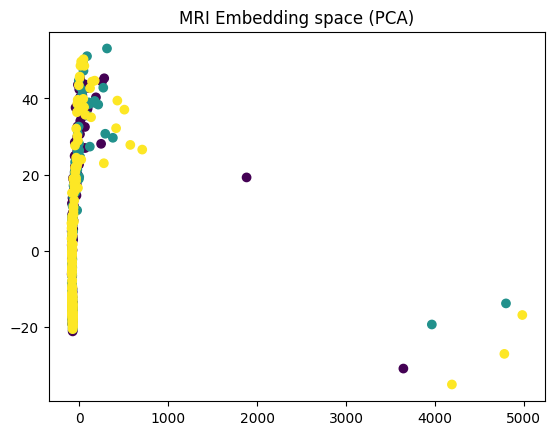

In [31]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_mri)
plt.scatter(X_2d[:,0], X_2d[:,1], c=pd.factorize(y)[0])
plt.title("MRI Embedding space (PCA)")
plt.show()


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_mri, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)

In [35]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=42)

In [36]:
y_pred = rf.predict(X_test)

In [37]:
print("MRI-only accuracy:", accuracy_score(y_test, y_pred))

MRI-only accuracy: 0.3162393162393162


In [ ]:
!zip -r MRI_Embeddings.zip /kaggle/working/MRI_Embeddings